In [ ]:
import os
BASE_DIR = f"..{os.sep}..{os.sep}..{os.sep}"
USE_DEEPNOTE = True # In case you would open this notebook via Deepnote

# SCRIPTS IMPORT
import os
import sys
scripts_path = os.path.abspath(os.path.join(f'{BASE_DIR}scripts'))

if scripts_path not in sys.path:
    # Add the scripts to the path
    sys.path.append(scripts_path)
    
    # Import the needed scripts
    from all_scripts import *
    
    # Remove the added path to avoid possible future conflicts
    sys.path.remove(scripts_path)
else:
    
    # Import the needed scripts
    from all_scripts import *
    
    # Remove the added path to avoid possible future conflicts
    sys.path.remove(scripts_path)

# PLOTS COLOR SETTING - see more here: https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette
PLOT_COLOR_SETTINGS = sns.color_palette("flare", as_cmap=True)

# LOAD DATA

### Training data

In [ ]:
FEATURES_TRAIN_UNNORMALIZED = pd.read_csv("../../models_input/melanoma_training.csv")

# Drop image_id for classification to avoid sequentail labeling
FEATURES_TRAIN_UNNORMALIZED = FEATURES_TRAIN_UNNORMALIZED.drop(['image_id'],axis=1)

# Normalize features
FEATURES_TRAIN = normalizeFeatures(FEATURES_TRAIN_UNNORMALIZED)

# Shuffle rows 
FEATURES_TRAIN = FEATURES_TRAIN.sample(frac=1).reset_index(drop=True)

### Validation data

In [ ]:
FEATURES_VAL_UNNORMALIZED = pd.read_csv("../../models_input/melanoma_validation.csv")

# Drop image_id for classification to avoid sequentail labeling
FEATURES_VAL_UNNORMALIZED = FEATURES_VAL_UNNORMALIZED.drop(['image_id'],axis=1)

# Normalize features
FEATURES_VAL = normalizeFeatures(FEATURES_VAL_UNNORMALIZED)

# Shuffle rows 
FEATURES_VAL = FEATURES_VAL.sample(frac=1).reset_index(drop=True)

In [ ]:
FEATURES_TRAIN.head()

,melanoma,compactness,assymetry,border_irr,color_spread
0,0,-0.438415,-0.695782,0.722172,1.504536
1,0,-0.469417,-0.299918,-0.643447,1.404332
2,0,-0.433832,-0.774303,-0.561804,-0.154260
3,0,-0.330035,-0.950902,1.652849,-1.064675
4,0,-0.477297,-0.740262,0.272160,0.691446


In [ ]:
FEATURES_VAL.head()

,melanoma,compactness,assymetry,border_irr,color_spread
0,0,-0.602031,-0.375773,1.360258,0.008025
1,0,-0.603082,-0.086052,0.512549,0.996170
2,0,1.165161,-0.903768,0.952564,-1.160321
3,1,0.027755,0.027432,-0.075891,0.206064
4,1,0.708343,-0.122369,-0.418084,-0.741782


### Plot features

<AxesSubplot:xlabel='melanoma', ylabel='color_spread'>

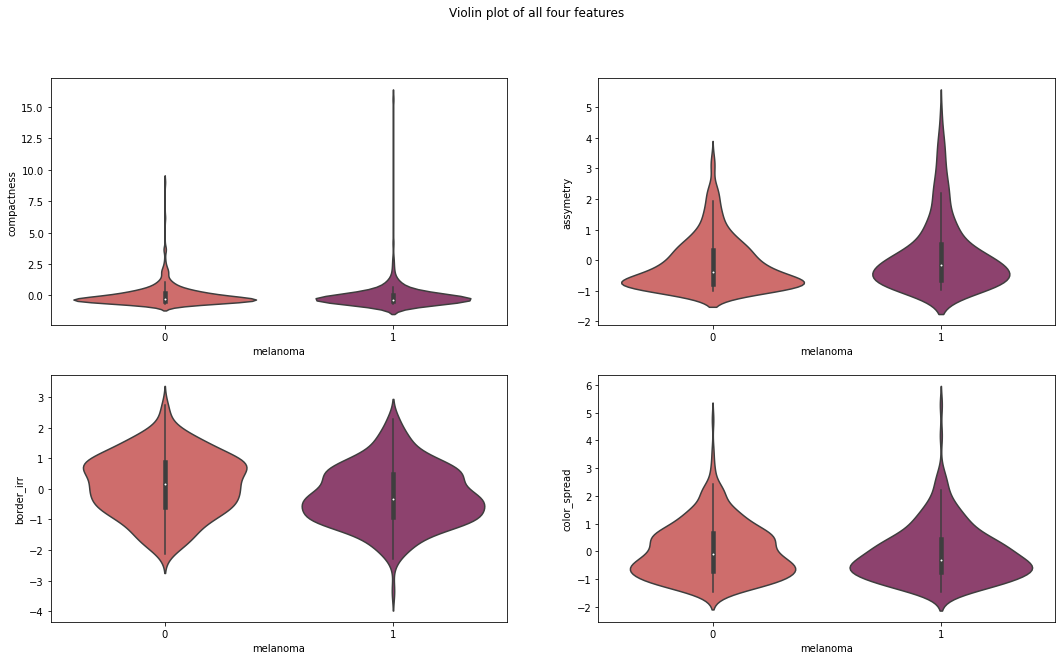

In [ ]:
# Plot all four variables in violin plot
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Violin plot of all four features')

sns.violinplot(ax=axes[0, 0], data=FEATURES_TRAIN, x='melanoma', y='compactness', palette = sns.color_palette("flare", n_colors=2))
sns.violinplot(ax=axes[0, 1], data=FEATURES_TRAIN, x='melanoma', y='assymetry', palette = sns.color_palette("flare", n_colors=2))
sns.violinplot(ax=axes[1, 0], data=FEATURES_TRAIN, x='melanoma', y='border_irr', palette = sns.color_palette("flare", n_colors=2))
sns.violinplot(ax=axes[1, 1], data=FEATURES_TRAIN, x='melanoma', y='color_spread', palette = sns.color_palette("flare", n_colors=2))

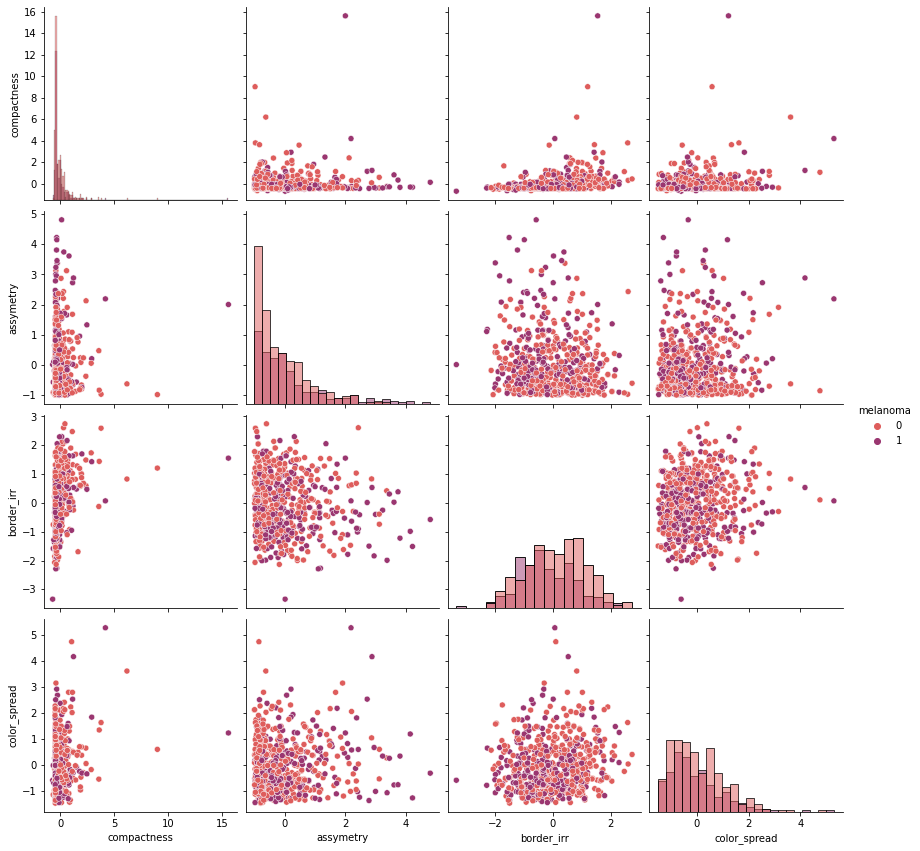

In [ ]:
# Pairplot (histograms correspond to violin plots)
sns.pairplot(FEATURES_TRAIN, hue="melanoma", height = 3, diag_kind="hist", palette = sns.color_palette("flare", n_colors=2));

Conclusion: We see a lot of class overlap. The biggest difference in distribution looks like border irregularity.

In [ ]:
# Select features of interest 
#selected_features = ['compactness', 'assymetry', 'border_irr', 'color_spread']

X = FEATURES_TRAIN[['compactness', 'assymetry', 'border_irr', 'color_spread']]
y = FEATURES_TRAIN["melanoma"].array

# THIS WILL ONLY BE USED FOR REPORTING!!
X_val = FEATURES_VAL[['compactness', 'assymetry', 'border_irr', 'color_spread']]
y_val = FEATURES_VAL["melanoma"].array

# Filter based feature selection

### Univariate feature selection on Numerical Input and Categorical Output

Correlation Statistics -> Selection Method

Correlation statistics:
Since we are dealing with _numeric_ input variables and a _categorical_ (dicrete) output/target variable: Correlation based measure but takes categorical output variable into accound. Use: 

- ANOVA correlation coefficient (linear): **f_classif()**
- Kendall’s rank coefficient (nonlinear). 

Mutual information is a also powerful method that may prove useful for both categorical and numerical data, e.g. it is agnostic to the data types. **mutual_info_classif()** and **mutual_info_regression()**

Selection Method: The scikit-learn library also provides many different filtering methods once statistics have been calculated for each input variable with the target. One of the more popular methods:

Select the top k variables: **SelectKBest**

Soruce: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

### Model-based vs. sequential feature selection

Soruce: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py 

In [ ]:
from sklearn.model_selection import train_test_split

# Add 10 noisy 'features' not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(FEATURES_TRAIN.shape[0], 10))

# Add the noisy data to the informative features
X_noise = np.hstack((FEATURES_TRAIN[['assymetry', 'compactness', 'border_irr', 'color_spread']], noise))
y_noise = FEATURES_TRAIN['melanoma']

# Split dataset to train and validation with noise
X_train_noise, X_val_noise, y_train_noise, y_val_noise = train_test_split(
        X_noise, y_noise, stratify=y)

# Split dataset to train and validation without noise
X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y)

In [ ]:
X_train.shape

(450, 4)

### Filtering methods: SelectKBest and LassoCV

<BarContainer object of 14 artists>

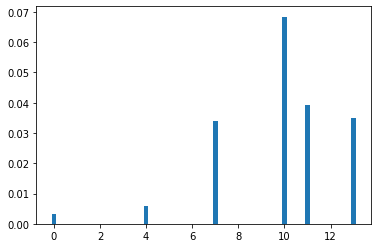

In [ ]:
# Univariate feature selection with mutual information for feature scoring
# Univariate statistical measures
from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k=2) # selecting 2
selector.fit(X_train_noise, y_train_noise)

scores = selector.scores_

plt.bar(np.arange(0,14), scores, width=.2,
        label=r'Feature score')


In [ ]:
def featureScores(X_train, y_train, k):
    '''This fucntion returns the importance scores 
    for each feature in the data set for univariate, filter-based feature selection.
    :X_train: Set of input variables for testing
    :y_train: Set of output variables for testing
    :k: Number of features to be selected (integer)
    '''
    from sklearn.feature_selection import mutual_info_classif, SelectKBest
    
    selector = SelectKBest(mutual_info_classif, k=k) # Selecting top k best festures sing mutual information for feature scoring
    selector.fit(X_train, y_train) # fit selector to data

    # Retrieve scores
    scores = selector.scores_

    return scores

In [ ]:
featureScores(X_train, y_train, 2)

array([0.        , 0.01978959, 0.0174457 , 0.01231056])

### Feature scores

Using the LassoCV estimator to get an idea of the importance of the features. Features with the highest absolute coef_ value are considered the most important.

[0.         0.05610873 0.05511007 0.00447214]


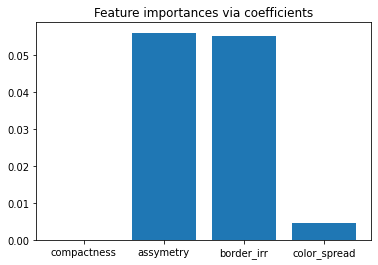

In [ ]:
from sklearn.linear_model import LassoCV

# Create LassoCV container
lasso = LassoCV()
lasso.fit(X_train, y_train)

# Get mnportance scores (coeffiecients)
importance = np.abs(lasso.coef_)
print(importance)

# Select all features
feature_names = ['compactness', 'assymetry', 'border_irr', 'color_spread']

# Plot their importance score
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

Select the two features which are the most important according to the coefficients using the SelectFromModel. This accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Selecting threshold to be right above the third most important feature
threshold = np.sort(scores)[-3] + 0.01

sfs = SequentialFeatureSelector(knn, n_features_to_select=3)

sfm = SelectFromModel(SelectKBest(lasso, threshold=threshold).fit(X_train, y_train)) # sfm.get_support() returns a boolean mask

#SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),n_features_to_select=3)

print(f'Features selected by SelectFromModel: {feature_names[sfm.get_support()]}')


TypeError: __init__() got an unexpected keyword argument 'threshold'

Using the SelectKBest estimator to get an idea of the importance of the features. Features with the highest scores_ value are considered the most important.

[0.         0.         0.01579533 0.00218692]


<BarContainer object of 4 artists>

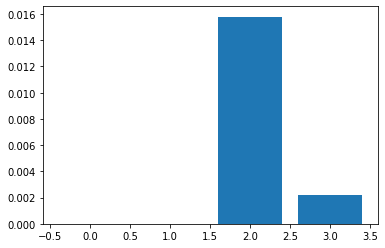

In [ ]:
# Univariate feature selection with mutual information for feature scoring
from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_
print(scores)

plt.bar(np.arange(0,4), scores)

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Selecting threshold to be right above the third most important feature
threshold2 = np.sort(scores)[-3] + 0.01
print(scores)
print(np.sort(scores))

sfm2 = SelectFromModel(selector, threshold=threshold2).fit(X_train, y_train) # sfm.get_support() returns a boolean mask

print(f'Features selected by SelectFromModel: {feature_names[sfm.get_support()]}')

[0.         0.         0.         0.02883072 0.         0.
 0.         0.         0.         0.01256558 0.01546388 0.00636342
 0.0081025  0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00636342 0.0081025  0.01256558
 0.01546388 0.02883072]


ValueError: when `importance_getter=='auto'`, the underlying estimator SelectKBest should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

### Selecting features with Sequential Feature Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

# Choosing 2 festures using sequential feature selection
sfs_forward = SequentialFeatureSelector(lasso, n_features_to_select=2, direction='forward').fit(X_train, y_train)

sfs_backward = SequentialFeatureSelector(lasso, n_features_to_select=2,
                                         direction='backward').fit(X_train, y_train)

print("Features selected by forward sequential selection: "
      f"{feature_names[sfs_forward.get_support()]}")

print("Features selected by backward sequential selection: "
      f"{feature_names[sfs_backward.get_support()]}")

TypeError: only integer scalar arrays can be converted to a scalar index

### Choosing a classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier

# Selecting only our own features (not noise)
X_train1 = X_train[:, 0:4]
X_train2 = selector.transform(X_train)

# Train a KNN classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1trained = knn1.fit(X_train2, y_train)

knn2 = KNeighborsClassifier(n_neighbors=3)
knn2trained = knn2.fit(X_train2, y_train)

# Train a Decision Tree classifier
tree = DecisionTreeClassifier() # various hyperparameters
treetrained = tree.fit(X_train2, y_train)

# Train a Nearest mean classifier
nmean = NearestCentroid() # using 'manhatten' distance will set centroid to be the mean
nmeantrained = nmean.fit(X_train2, y_train)


In [ ]:
#Select the same features as before
X_val1 = X_val[:, 0:4]
X_val2 = selector.transform(X_val)

y_val_knn1 = knn1trained.predict(X_val2)
y_val_knn2 = knn2trained.predict(X_val2)

y_val_tree = treetrained.predict(X_val2)

y_val_nmean = nmeantrained.predict(X_val2)

# Simple accuracy
print(np.sum(y_val_knn1 == y_val) / np.size(y_val) * 100)
print(np.sum(y_val_knn2 == y_val) / np.size(y_val) * 100)

56.14035087719298
56.14035087719298


In [ ]:
from sklearn.metrics import accuracy_score

acc_knn1 = accuracy_score(y_val, y_val_knn1)
acc_knn2 = accuracy_score(y_val, y_val_knn2)

acc_tree = accuracy_score(y_val, y_val_tree)

acc_nmean = accuracy_score(y_val, y_val_nmean)

print(f'KNN: 1: {acc_knn1}, 2: {acc_knn2}, \nTree: {acc_tree} \nnMean: {acc_nmean}')


KNN: 1: 0.5614035087719298, 2: 0.5614035087719298, 
Tree: 0.49122807017543857 
nMean: 0.3508771929824561


In [ ]:
from sklearn.metrics import roc_auc_score

roc_knn1 = roc_auc_score(y_val, y_val_knn1)
roc_knn2 = roc_auc_score(y_val, y_val_knn2)

roc_tree = roc_auc_score(y_val, y_val_tree)

roc_nmean = roc_auc_score(y_val, y_val_nmean)

print(f'KNN: 1: {roc_knn1}, 2: {roc_knn2}, \nTree: {roc_tree} \nnMean: {roc_nmean}')

KNN: 1: 0.5479539641943734, 2: 0.5198209718670077, 
Tree: 0.4750639386189258 
nMean: 0.36445012787723785


Evaluating classifiers: Confusion Matrix 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_val_knn2)

array([[25,  9],
       [16,  7]])

In [ ]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2) # no. of floating point decimals

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn2, X_test, y_test,
                                 display_labels = class_names,
                                 cmap = plt.cm.Blues,
                                 normalize = normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

NameError: name 'svm' is not defined

In [ ]:
# ONLY FOR REPORTING, also evaluate on test set
X_test = X_test[:, [0,1]]

y_test_knn1 = knn2trained.predict(X_test)

acc_test = accuracy_score(y_test, y_test_knn1)
auc_test = roc_auc_score(y_test, y_test_knn1)

print(acc_test)
print(auc_test)

0.3815789473684211
0.4075268817204301


### Old code - also adding random noise features

<BarContainer object of 14 artists>

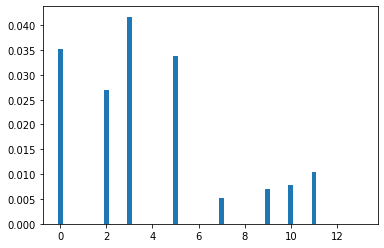

In [ ]:
from sklearn.model_selection import train_test_split

# Some noisy data not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(FEATURES_TRAIN.shape[0], 10))

# Add the noisy data to the informative features
X = np.hstack((FEATURES_TRAIN[['assymetry', 'compactness', 'border_irr', 'color_spread']], noise))
y = FEATURES_TRAIN['melanoma']

# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)


# Univariate feature selection with mutual information for feature scoring
from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_

plt.bar(np.arange(0,14), scores, width=.2,
        label=r'Feature score')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2a47fbf6-c653-4328-90db-f0771def66a6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>